In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from pymeasure.adapters import VXI11Adapter 
from T3AWG3252 import T3AWG3252, upload_signal_teledyne

# 1) Get the network adapter using the VXI11 protocol

In [ ]:
ip_addr = '192.168.1.88'
conn_adapter = VXI11Adapter(host=ip_addr)

# 2) Get the T3AWG3252 arbitrary wave generator

In [ ]:
awg = T3AWG3252(conn_adapter)
print(awg.idn())

ACTIVE TECHNOLOGIES,AWG3252,T0302I19050303,SCPI:1999.0,SV:1.1.3.0


# 3) Functions for generating signals

In [ ]:
def generate_square_signal(fc,fs,phase=0):
    """
    Generates a square wave with a period of 2*pi, with has a value of 
    +0 from 0 to phase
    +1 from phase to phase+pi
    +0 from phase+pi + 2*pi
    
    Args:
        fc (float): Carrier frequency in Hz. 1/T where T is the period of the square signal
        fs (float): Sampling frequency in Hz. The number of samples per second
        phase (float): Phase in radians
    Returns:
        samples: The signal generated samples
    """
    num_samples = np.round(period * fs).astype(int)
    zero_samples = np.round((1 - phase / np.pi) * num_samples/2).astype(int)
    ones_samples = np.round(num_samples / 2).astype(int)
    samples = np.concatenate([np.zeros(zero_samples),
                              np.ones(ones_samples),
                              np.zeros(ones_samples-zero_samples)])
    fs = len(samples) / period
    return samples

def generate_sin_signal(fc,fs,phase,cycles):
    """
    Generates a sinusoid wave.
    
    Args:
        fc (float): Carrier frecuency in Hz. 1/T where T is the period of the sinusoid signal.
        fs (floagt): Sampling frequency in Hz. The number of samples per second.
        phase (float): Phase in radians
    Returns:
        samples: The signal generated samples
        t: The time reference
    """
    period = 1/fc
    num_samples = int(cycles * period * fs)
    t = np.linspace(0,cycles * period,num_samples)
    k = 2 * np.pi * fc * t + phase
    samples = np.sin(k)
    return samples, t

# 5) Experiments
## 5.1) Generate example signals

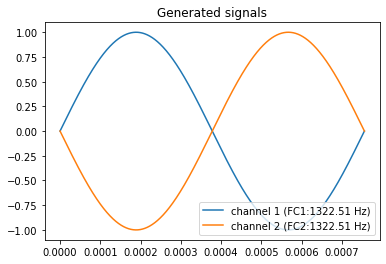

In [ ]:
CAMERA_SAMPLING=18.9035e-6           # The sampling time (row sampling time) of the camera (PiCamera V2)
CAMERA_FS=1/CAMERA_SAMPLING          # The sampling frequency of the camera (PiCamera V2)
RX_NUM_SAMPLES = 40                  # The number of samples per cycle at the receiver side.

FC1 = CAMERA_FS / RX_NUM_SAMPLES     # The carrier frequency of the transmitted signal (channel 1)
PHASE1 = 0                           # The phase of the transmitted signal (channel 1)
FC2 = CAMERA_FS / RX_NUM_SAMPLES     # The carrier frecuency of the transmitted signal (channel 2)
PHASE2 = np.pi                       # The phase of the transmitted signal (channel 2)

if FC2 < FC1:
    CYCLES1=FC1/FC2
    CYCLES2=1
else:
    CYCLES1=1
    CYCLES2=FC2/FC1

TX_NUM_SAMPLES = 10000               # The number of samples per cycle at the transmitter side.
FS = FC1 * TX_NUM_SAMPLES            # The sampling frequency of the transmitter

samples_chn1, t1 = generate_sin_signal(FC1, FS, PHASE1, CYCLES1)
samples_chn2, t2 = generate_sin_signal(FC2, FS, PHASE2, CYCLES2)

plt.plot(t1, samples_chn1, label="channel 1 (FC1:{:.2f} Hz)".format(FC1))
plt.plot(t2, samples_chn2, label="channel 2 (FC2:{:.2f} Hz)".format(FC2))
plt.title("Generated signals")
plt.legend(loc="lower right")

upload_signal_teledyne(awg, name="temp1", samples=samples_chn1, amp=3, fs = FS, channel=1, run=False)
upload_signal_teledyne(awg, name="temp2", samples=samples_chn2, amp=3, fs = FS, channel=2, run=True)

## 5.2 Generate experiment SIN. FREQ and PHASE
The transmitted signal are two sinusoids in which the frequency and phase changes
### 5.2.1 Define sample set

In [ ]:
CAMERA_SAMPLING=18.9035e-6           # The sampling time (row sampling time) of the camera (PiCamera V2)
CAMERA_FS=1/CAMERA_SAMPLING          # The sampling frequency of the camera (PiCamera V2)
RX_NUM_SAMPLES = 40                  # The number of samples per cycle at the receiver side.

FC1 = CAMERA_FS / RX_NUM_SAMPLES     # The carrier frequency of the transmitted signal (channel 1)
PHASE1 = 0                           # The phase of the transmitted signal (channel 1)

FCS2 = np.asarray([1,1/2,1/3]) * CAMERA_FS / RX_NUM_SAMPLES  # The carrier frecuencies of the transmitted signal (channel 2)
PHASES2 = np.arange(0,8+1)*1/8*np.pi                         # The phases of the transmitted signal (channel 2). From 0 to pi in steps of 1/8 pi

print(PHASES2)
TX_NUM_SAMPLES = 10000               # The number of samples per cycle at the transmitter side.
FS = FC1 * TX_NUM_SAMPLES            # The sampling frequency of the transmitter

NUM_SAMPLES_SET = 4

NAME="EXP_{}us-AG_{}-SAMPLES-{}_CHN1_freq-{:0.2f}Hz-phase-{:0.2f}_CHN2_freq-{:0.2f}Hz-phase-{:0.2f}_idx-{}.jpg"

EXP = 85
AG = 4

[0.         0.39269908 0.78539816 1.17809725 1.57079633 1.96349541
 2.35619449 2.74889357 3.14159265]


### 5.2.2 Generate sample set

In [ ]:
import time
for i in range(NUM_SAMPLES_SET):
    for FC2 in FCS2:
        for PHASE2 in PHASES2: 
            if FC2 < FC1:
                CYCLES1=FC1/FC2
                CYCLES2=1
            else:
                CYCLES1=1
                CYCLES2=FC2/FC1
            samples_chn1, t1 = generate_sin_signal(FC1, FS, PHASE1, CYCLES1)
            samples_chn2, t2 = generate_sin_signal(FC2, FS, PHASE2, CYCLES2)
            upload_signal_teledyne(awg, name="temp1", samples=samples_chn1, amp=3, fs = FS, channel=1, run=False)
            upload_signal_teledyne(awg, name="temp2", samples=samples_chn2, amp=3, fs = FS, channel=2, run=True)
            time.sleep(1)
            # img = capture_image(EXP, AG, NAME.format(EXP, AG, RX_NUM_SAMPLES, FC1, PHASE1, FC2, PHASE2, int(i)), False)